To Do:
* Review and clean up this script
* Update training script to save best weights periodically
* Update training script to save plots periodically
* Update training script to save performance information periodically
* Add means to detect training completion (and optionally shut down the instance)
* Develop a method to run inference using the weights
* Develop an method to visualize the inference results



In [1]:
# This cell loads test and training splits.

from torchvision import transforms
from dvmcar import DvmCarDataset

# load_data - return dvmcar training and validation datasets
#
# locale - specifies environment in which code is exectuting since paths may need
#   to be modified.
#     "Lambda Labs"
#     "Default"
# scale - fraction of dataset to use, 1 uses the entire dataset

def load_data(locale="Default", scale=0.05):

    # Depending on the locale...
    if locale=="Lambda Labs":
        # Use lambda labs paths
        work_def = '/home/ubuntu/WorkLab/data/dvmcar/dvmcar.zip'
        persist_def = '/home/ubuntu/worklab/dvmcar.zip'
    else:
        # Use default paths
        work_def = '/data/dvmcar/dvmcar.zip'
        persist_def = None

    # Set partitions for train, test, and validate subsets
    partition0  = 0.8*scale
    partition1  = 0.9*scale
    partition2  = 1.0*scale

    # Define corresponding split arguments for the dataset constructor
    train_split = [0,          partition0]
    val_split   = [partition0, partition1]
    test_split  = [partition1, partition2]
    
    # Resnet input height & width?
    input_size  = 224

    # Specify training transform stack
    # Not too sure what random resize crop does...
    # Per Derek - maybe color space & other distortions would be useful?
    train_transform = transforms.Compose([
            transforms.RandomResizedCrop(input_size),
            transforms.RandomHorizontalFlip(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) ])

    # Specify validation transform stack
    val_transform = transforms.Compose([
            transforms.Resize(input_size),
            transforms.CenterCrop(input_size),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) ])

    train_data  = DvmCarDataset(split = train_split, transform = train_transform, work = work_def, persist = persist_def)
    val_data    = DvmCarDataset(split =   val_split, transform =   val_transform, work = work_def, persist = persist_def)
    
    return(train_data, val_data)

(train_data, val_data) = load_data()

print('Training split contains {:7} images.'.format(len(train_data)))
print('Validation split contains {:7} images.'.format(len(val_data)))

Work file /data/dvmcar/dvmcar.zip is already available.
Using existing /data/dvmcar\resized_DVM_v2.zip.
Using existing /data/dvmcar\Confirmed_fronts.zip.
Using existing /data/dvmcar\tables_V2.0.zip.
Work file /data/dvmcar/dvmcar.zip is already available.
Using existing /data/dvmcar\resized_DVM_v2.zip.
Using existing /data/dvmcar\Confirmed_fronts.zip.
Using existing /data/dvmcar\tables_V2.0.zip.
Training split contains   58071 images.
Validation split contains    7259 images.


KeyboardInterrupt: 

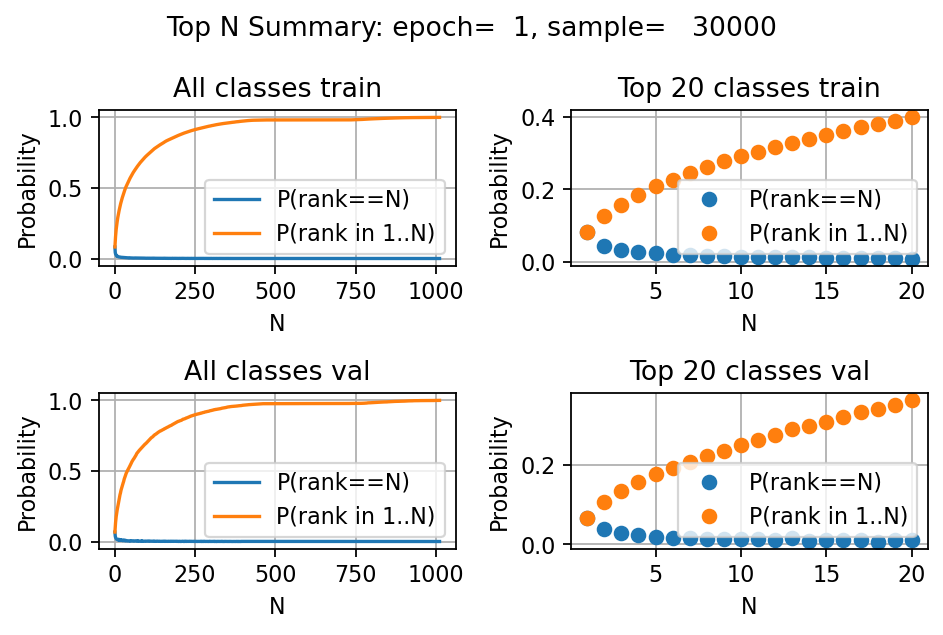

In [2]:
# Import a lot of stuff
from IPython.display import display, clear_output
import matplotlib.pyplot as plt
import time
import os
import copy
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
from torchvision import models

%matplotlib inline

class stat_accumulator:

    def __init__(self, classes):
        self.classes = classes
        self.top = np.zeros(self.classes)
        self.count = 0
        
    def update(self, labels, outputs):
        
        # Get indices (labels) sorting the vector in decreasing order
        top_indices = torch.argsort(outputs, 1, descending=True)

        # Find predicted ranking of the true class for each result in the batch
        n = [(top_indices[k]==labels.data[k]).nonzero().squeeze().item() for k in range(len(labels.data))]

        # For each result in the batch...
        for idx in n:

            # Increment
            self.top[idx] += 1
            
        self.count += len(labels.data)
        
        return(self.top[0]/self.count, self.count, self.top/self.count)
        
class statplotter:
    
    def __init__(self):
        plt.rcParams['figure.dpi'] = 160
        self.fig = plt.figure() 
        self.ax1 = self.fig.add_subplot(2, 2, 1)
        self.ax2 = self.fig.add_subplot(2, 2, 2)
        self.ax3 = self.fig.add_subplot(2, 2, 3)
        self.ax4 = self.fig.add_subplot(2, 2, 4)
        
    def update(self, rank_count, phase, epoch, sample):
        
        # Update plot

        self.fig.suptitle('Top N Summary: epoch={:3}, sample={:8}'.format(
            epoch, sample))

        clear_output(wait = True)
        x = np.arange(rank_count.size)+1
        
        max_n = 20
            
        if phase=="train":
            
            self.ax1.cla()
            self.ax1.plot(x,          rank_count , label='P(rank==N)')
            self.ax1.plot(x,np.cumsum(rank_count), label='P(rank in 1..N)')
            self.ax1.set_title('All classes train')
            self.ax1.legend()
            self.ax1.grid()
            self.ax1.set_ylabel('Probability')
            self.ax1.set_xlabel('N')    

            self.ax2.cla()
            self.ax2.plot(x[:max_n],          rank_count[:max_n] , label='P(rank==N)', linestyle='None', marker='o')
            self.ax2.plot(x[:max_n],np.cumsum(rank_count[:max_n]), label='P(rank in 1..N)', linestyle='None', marker='o')
            self.ax2.set_title('Top {} classes train'.format(max_n))
            self.ax2.legend()
            self.ax2.grid()
            self.ax2.set_ylabel('Probability')
            self.ax2.set_xlabel('N')    
            
        else:
            
            self.ax3.cla()
            self.ax3.plot(x,          rank_count , label='P(rank==N)')
            self.ax3.plot(x,np.cumsum(rank_count), label='P(rank in 1..N)')
            self.ax3.set_title('All classes val')
            self.ax3.legend()
            self.ax3.grid()
            self.ax3.set_ylabel('Probability')
            self.ax3.set_xlabel('N')    

            self.ax4.cla()
            self.ax4.plot(x[:max_n],          rank_count[:max_n] , label='P(rank==N)', linestyle='None', marker='o')
            self.ax4.plot(x[:max_n],np.cumsum(rank_count[:max_n]), label='P(rank in 1..N)', linestyle='None', marker='o')
            self.ax4.set_title('Top {} classes val'.format(max_n))
            self.ax4.legend()
            self.ax4.grid()
            self.ax4.set_ylabel('Probability')
            self.ax4.set_xlabel('N')  
            
        self.fig.tight_layout() 
        
        display(self.fig)    

        #print('Epoch={:3} / Sample={:8}'.format(epoch, sample), end='\r', flush=True)     
# Provide learning and inference methods

class model_manager:
    
    def __init__(self, classes):
        
        # Input image height and width
        self.image_size = 224
        
        # Set number of output classes
        self.classes = classes
        
    def train(self, datasets, 
        checkpoint_file = "DvmCar.pt",
        weight_file = "DvmCar.wt",
        batch_size = 50,
        max_epochs = 100,
        max_hours = 24,
        checkpoint_minutes = 10,
        plot_samples = 2000,
        learning_rate = 0.05,
        feature_extract = True,
        resume = False):
        
        # Create training and validation dataloaders
        dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4) for x in ['train', 'val']}
        
        # Clear epoch
        epoch = 0
        
        # Clear loss
        loss = 0
        
        # Clear accuracy
        accuracy = 0
        
        best_acc = 0
        
        # Record time at start of training
        training_start = time.time()       
        
        plotter = statplotter()
        
        val_acc_history = []
        
        # Start the checkpoint timer
        checkpoint_timer = training_start
                
        # Start with standard resnet 50
        model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)

        # Replace fully connected layer with the required number of output classes
        # (These will have requires_grad = True)
        model.fc = nn.Linear(model.fc.in_features, self.classes)
        
        # Empty parameter list
        params_to_update = []

        # For each parameter in the list...
        for name, param in model.named_parameters():

            # Determine whether to update this parameter
            param.requires_grad = (not feature_extract) or ((name=="fc.weight") or (name=="fc.bias"))
            
            # If updating this parameter
            if param.requires_grad:

                # Append it to the parameter list
                params_to_update.append(param)

        # Create optimizer
        optimizer = optim.AdamW(params_to_update, lr = learning_rate)         
        
        # Setup the loss function
        criterion = nn.CrossEntropyLoss()
        
        # If resuming training from checkpoint...
        if resume:
            
            checkpoint = torch.load(checkpoint_file)
            model.load_state_dict(checkpoint['model_state_dict'])
            optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
            epoch = checkpoint['epoch']
            loss = checkpoint['loss']
            accuracy = checkpoint['accuracy']
            
        else:

            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': loss,
                'accuracy': accuracy}, checkpoint_file) 

        # Detect if we have a GPU available
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

        # Send the model to GPU
        model = model.to(device)
                    
        # Clear completion flag
        training_complete = False
        
        # While training remains incomplete...
        while not training_complete:
        
            # Log epoch start
            # self.log_epoch_start(epoch)
            print("Epoch Start: {}".format(epoch))

            # For each phase...
            for phase in ['train', 'val']:
                

                
                # Depending on the phase
                if phase == 'train':
                    
                    # Set model to training mode
                    model.train()
                    
                else:
                    
                    # Set model to evaluate mode
                    model.eval()   

                # Clear accumulators
                running_loss = 0.0
                running_corrects = 0
                sample = 0
                # Start the plot timer
                plot_sample = 0
                
                stats = stat_accumulator(self.classes)

                # For each minibatch...
                for inputs, labels in dataloaders[phase]:
                    
                    # Move inputs and labels to GPU
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # Update sample counter
                    sample += inputs.size(0)

                    # Clear gradients
                    optimizer.zero_grad()

                    # forward
                    # track history only if training
                    with torch.set_grad_enabled(phase == 'train'):
                        
                        # Get model outputs
                        outputs = model(inputs)
                        
                        # Calculate loss
                        loss = criterion(outputs, labels)

                        # Use maximal class activations as predictions
                        _, preds = torch.max(outputs, 1)
                        
                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()
                            
                    # Update running statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                    
                    accuracy, count, top = stats.update(labels, outputs)
                    
                    # Get present time
                    now = time.time()

                    
                    if sample-plot_sample>= plot_samples:
                        
                        plotter.update(top, phase, epoch, sample)                        
                    
                        plot_sample += plot_samples
                        
                    # If elapsed time exceeds limit...
                    if now - checkpoint_timer >= checkpoint_minutes*60:
                        
                        torch.save({
                            'epoch': epoch,
                            'model_state_dict': model.state_dict(),
                            'optimizer_state_dict': optimizer.state_dict(),
                            'loss': loss,
                            'accuracy': accuracy}, checkpoint_file) 
                        
                        # Reset checkpoint timer
                        checkpoint_timer = now
                    
                    # If elapsed training time exceeds limit...
                    if now - training_start >= max_hours*3600:
                        
                        # Training is complete
                        training_complete = True
                        
                        # Max time exceeded
                        completion_criteria = "Time"    
            
                    # Update epoch statistics
                    epoch_loss = running_loss / len(dataloaders[phase].dataset)
                    epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

                    # print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

                # If validation phase...
                if phase == 'val':
                
                    # Update eopoch accuracy list
                    val_acc_history.append(epoch_acc)
                    
                    # If validation performance improved...
                    if epoch_acc > best_acc:
                        
                        # Update best performance
                        best_acc = epoch_acc
                        
                        # Save best model weights
                        torch.save({
                            'epoch': epoch,
                            'model_state_dict': model.state_dict(),
                            'optimizer_state_dict': optimizer.state_dict(),
                            'loss': loss,
                            'accuracy': accuracy}, weight_file)
                        
                        # Reset got worse count
                        got_worse = 0
                        
                    else:
                        
                        # Increment got worse count
                        got_worse += 1
                        
                        # If got worse too many times
                        if got_worse > 1:
                            
                            # Stop training
                            training_complete = True
                            
                            # Quit due to overfitting / decreasing accuracy
                            completion_criteria = "Accuracy"
                            
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': loss,
                'accuracy': accuracy}, checkpoint_file) 
            
            # Increment epoch counter
            epoch += 1
            
            if epoch>=max_epochs:
                training_complete = True
                completion_criteria = "Epochs"

        #time_elapsed = time.time() - start_time
        #print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
        #print('Best val Acc: {:4f}'.format(best_acc))

        # load best model weights
        model.load_state_dict(best_model_wts)
        model.load_state_dict(torch.load(self.model_path))
        model.eval()
        return model, val_acc_history
    
     
    
# Create training and validation datasets
image_datasets = {'train': train_data, 'val' : val_data}

manager = model_manager(train_data.classes)
manager.train(image_datasets)

In [ ]:
print('Busy')

In [ ]:
# Writes a csv containing every make and model combination in the dataset
def util_list_make_model(dataset):
    
    maker_list = list(dataset.basic_df['Automaker'])
    model_list = list(dataset.basic_df['Genmodel'])

    mm_fields = list(set([r[0]+','+r[1] for r in zip(maker_list, model_list)]))
    mm_fields.sort()

    with open('dvmcars_make_model.csv','w') as out:
        out.write('dvmcars-make,dvmcars-model\n')
        for r in mm_fields:
            out.write(r+'\n')
            
# util_list_make_model(train_data)